## Exercise 1

For this exercise, we will use the `adult` dataset (available on moodle or from the [UCI Machine Learning repository](https://archive.ics.uci.edu/dataset/2/adult)). Do the following:

1. Load in the dataset and correct the error in the income column (replace the "." with the empty string such that there are only two categories).
2. Create an X dataset using the variables "age", "workclass", "education", "occupation", "race", "sex", "hours-per-week". For the categorical variables with missing values, replace the missing values with a new category "Unknown". Also replace any values that are "?" with the value "Unknown (using `str.replace`, for instance)
3. Turn the five categorical variables in X into dummy variables and remove the original five variables (This will probably give you around 44 columns in X)
4. Create the response variable y, such that it is 1 if the `income` variable in the adult dataset is `>50K` and 0 if the value is `<=50K`.
5. Do a train-test split with 30% of the data for test (using `random_state=123`) and train a `XGBoost` classification model on the training data.
6. Evaluate your models using various evaluation metrics and look at the confusion matrix of your model.
7. To be able to calculate the various fairness metrics in regard to the variable `sex`, we need to construct two separate confusion matrices for the test dataset, one for `female` and one for `male`. First, create separate test sets for `female` and `male` as well as the predicted values for each gender. That is, create `X_test_female`, `X_test_male`, `y_test_female`, `y_test_male`, `y_pred_female`, and `y_pred_male`. (Hint: You can create `X_test_female` by `X_test_female = X_test[X_test["sex_Male"] == 0]` and `y_test_male` by `y_test_male = y_test[X_test["sex_Male"] == 1]`, for instance.)
8. Calculate the accuracy for female and male for the XGBoost model and comment on the results.
9. We can now create the True Positive (TP), True Negative (TN), False Positive (FP), and False Negative (FN) for each gender. That is, calculate the eight values `TP_f`, `TN_f`, `FP_f`, `FN_f`, `TP_m`, `TN_m`, `FP_m`, and `FN_m`. (Hint: You can calculate the False Positive for female (FP_f) by `FP_f = sum((y_test_female == 0) & (y_pred_female == 1))`.)
10. Is there error rate balance across different genders, i.e. are the false positive rate (FPR) and false negative rate (FNR) the same across the two genders?
11. Is there predictive parity across different genders?
12. Is there Statistical parity across different genders?
13. [Discussion question] Can your any of your models be used to make fair salary predictions?
14. [Discussion question] In what sense is the `adult` dataset biased (unfair)?
15. [Discussion question] If the dataset is biased, where could the bias potentially come from?
16. [Optional] If you balance the number of males and females in the dataset (like we balanced the response variable in the Churn example), will you model become more fair?

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import xgboost as xgb
import scipy.sparse

1. Load in the dataset and correct the error in the income column (replace the "." with the empty string such that there are only two categories).

In [2]:
#Load Data
df = pd.read_csv("Datasets/adult.csv")

In [3]:
#Clean the income column
df["income"] = df["income"].apply(lambda x: x.strip("."))

2. Create an X dataset using the variables "age", "workclass", "education", "occupation", "race", "sex", "hours-per-week". For the categorical variables with missing values, replace the missing values with a new category "Unknown". Also replace any values that are "?" with the value "Unknown (using `str.replace`, for instance)


In [4]:
#Feature & target variables selection
X = df[["age", "workclass", "education","occupation", "race", "sex","hours-per-week"]]

In [5]:
#Handle missing values 
X.replace("?", "Unkown", inplace=True)
X = X.fillna("Unkown")

#Verify that missing values are eliminated
if X.isnull().sum().values.all() == 0 : print("There are no missing values")

#Verify there is not ? 
if X[X.values == "?"].empty: print("There are no more ? in the categorical data")


There are no missing values
There are no more ? in the categorical data


C:\Users\davor\AppData\Local\Temp\ipykernel_8980\1391407957.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.replace("?", "Unkown", inplace=True)


3. Turn the five categorical variables in X into dummy variables and remove the original five variables (This will probably give you around 44 columns in X)

In [6]:
#One hot encoding
X = pd.get_dummies(X, columns=["workclass", "education", "occupation", "race", "sex"], drop_first=True, dtype=int)

4. Create the response variable y, such that it is 1 if the `income` variable in the adult dataset is `>50K` and 0 if the value is `<=50K`.

In [7]:
y = (df["income"] == ">50K").astype(int) # Binary classification target

5. Do a train-test split with 30% of the data for test (using `random_state=123`) and train a `XGBoost` classification model on the training data.

In [8]:
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [9]:
#Convert to Dmatrix for optimization
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [10]:
#Define XGBoost parameters
params = {
    "objective":"binary:logistic",
    'eval_metric':'logloss', #Try with error,
    "random_state": 123,
    "max_depth":5
}

#Train the model
model = xgb.train(params, dtrain, num_boost_round=100)

#Make prediction
y_pred = (model.predict(dtest) > 0.5).astype(int)

6. Evaluate your models using various evaluation metrics and look at the confusion matrix of your model.

Accuracy 0.8229031597625059
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.93      0.89     11166
           1       0.68      0.47      0.56      3487

    accuracy                           0.82     14653
   macro avg       0.77      0.70      0.72     14653
weighted avg       0.81      0.82      0.81     14653



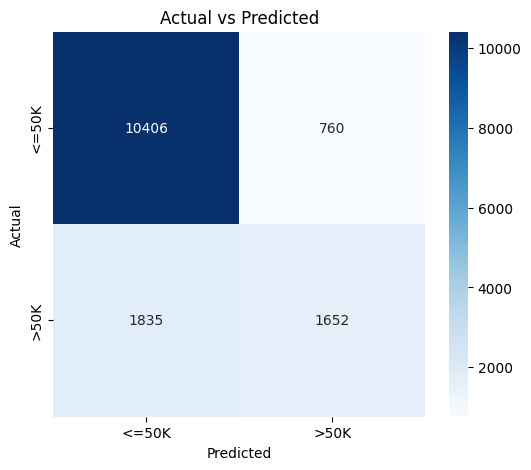

In [11]:
#Model Evaluation
print("Accuracy",accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

#Plot confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["<=50K", ">50K"], yticklabels=["<=50K", ">50K"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Actual vs Predicted")
plt.show()

7. To be able to calculate the various fairness metrics in regard to the variable `sex`, we need to construct two separate confusion matrices for the test dataset, one for `female` and one for `male`. First, create separate test sets for `female` and `male` as well as the predicted values for each gender. That is, create `X_test_female`, `X_test_male`, `y_test_female`, `y_test_male`, `y_pred_female`, and `y_pred_male`. (Hint: You can create `X_test_female` by `X_test_female = X_test[X_test["sex_Male"] == 0]` and `y_test_male` by `y_test_male = y_test[X_test["sex_Male"] == 1]`, for instance.)

In [12]:
#Fairness analysis: Separate test sets by gender
X_test_female = X_test[X_test['sex_Male'] == 0]
X_test_male = X_test[X_test['sex_Male'] == 1]
y_test_female = y_test[X_test['sex_Male'] == 0]
y_test_male = y_test[X_test['sex_Male'] == 1]

dtest_female = xgb.DMatrix(X_test_female)
dtest_male = xgb.DMatrix(X_test_male)

y_pred_female = (model.predict(dtest_female) > 0.5).astype(int)
y_pred_male = (model.predict(dtest_male) > 0.5).astype(int)

8. Calculate the accuracy for female and male for the XGBoost model and comment on the results.

In [13]:
#Fairness Metrics
accuracy_female = accuracy_score(y_test_female, y_pred_female)
accuracy_male = accuracy_score(y_test_male, y_pred_male)
print(f"Accuracry Female: {accuracy_female:.3f}\naccuracy Male:{accuracy_male:.3f}")

Accuracry Female: 0.900
accuracy Male:0.784


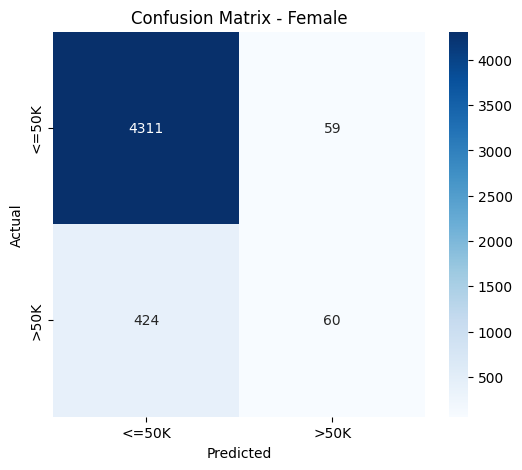

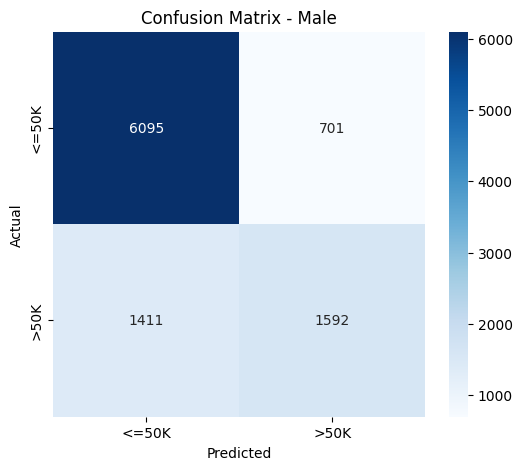

In [14]:
#Plot gender-based confusion matrices
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test_female, y_pred_female, "Confusion Matrix - Female")
plot_confusion_matrix(y_test_male, y_pred_male, "Confusion Matrix - Male")

9. We can now create the True Positive (TP), True Negative (TN), False Positive (FP), and False Negative (FN) for each gender. That is, calculate the eight values `TP_f`, `TN_f`, `FP_f`, `FN_f`, `TP_m`, `TN_m`, `FP_m`, and `FN_m`. (Hint: You can calculate the False Positive for female (FP_f) by `FP_f = sum((y_test_female == 0) & (y_pred_female == 1))`.)

In [15]:
# Confusion matrix values
TP_f = sum((y_test_female == 1) & (y_pred_female == 1))
TN_f = sum((y_test_female == 0) & (y_pred_female == 0))
FP_f = sum((y_test_female == 0) & (y_pred_female == 1))
FN_f = sum((y_test_female == 1) & (y_pred_female == 0))

TP_m = sum((y_test_male == 1) & (y_pred_male == 1))
TN_m = sum((y_test_male == 0) & (y_pred_male == 0))
FP_m = sum((y_test_male == 0) & (y_pred_male == 1))
FN_m = sum((y_test_male == 1) & (y_pred_male == 0))

print(f"TP_f: {TP_f}, TN_f: {TN_f}, FP_f: {FP_f}, FN_f: {FN_f}")
print(f"TP_m: {TP_m}, TN_m: {TN_m}, FP_m: {FP_m}, FN_m: {FN_m}")

TP_f: 60, TN_f: 4311, FP_f: 59, FN_f: 424
TP_m: 1592, TN_m: 6095, FP_m: 701, FN_m: 1411


10. Is there error rate balance across different genders, i.e. are the false positive rate (FPR) and false negative rate (FNR) the same across the two genders?

In [16]:
# False positive & false negative rates
FPR_f = FP_f / (FP_f + TN_f)
FNR_f = FN_f / (FN_f + TP_f)
FPR_m = FP_m / (FP_m + TN_m)
FNR_m = FN_m / (FN_m + TP_m)
print(f"FPR Female: {FPR_f:.3f}, FNR Female: {FNR_f:.3f}")
print(f"FPR Male: {FPR_m:.3f}, FNR Male: {FNR_m:.3f}")

FPR Female: 0.014, FNR Female: 0.876
FPR Male: 0.103, FNR Male: 0.470


There is no error rate balance, as both FPR and FNR differ significantly between males and females.
The model predicts high income for males much more often that for females and in addition the model fails to predict high income for females much more often thatn for males.
Overall, the model underestimates high-imcome females and overestimates high-income males.

11. Is there predictive parity across different genders?

In [17]:
#Calcualte PPV for males and females
PPV_M = TP_m / (TP_m + FP_m)
print(f"Predivtive parity Males(Precision):{PPV_M}") #Correctly identifying high income males
PPV_F = TP_f / (TP_f + FP_f)
print(f"Predivtive parity Females(Precision):{PPV_F}") #Correctly identifying high income males

Predivtive parity Males(Precision):0.6942869603139992
Predivtive parity Females(Precision):0.5042016806722689


There is some differnece in predictive parity, since the model has slightly higher precision for predicting high income males compared to females. 

12. Is there Statistical parity across different genders?

In [18]:
#Calcualte statistical parity
stat_M = ((TP_m + FP_m) / len(X_test_male)) * 100
print(f"Statistical parity for males:{stat_M:.1f}%")
stat_F = ((TP_f + FP_f) / len(X_test_female)) * 100
print(f"Statistical parity for females:{stat_F:.1f}%")

Statistical parity for males:23.4%
Statistical parity for females:2.5%


There is not statistical parity as the model predicts more high incomes for males.

13. [Discussion question] Can your any of your models be used to make fair salary predictions?

The model is not fair and highly biased towards males, so is cant be used to make fair salary predictions.

14. [Discussion question] In what sense is the `adult` dataset biased (unfair)?
15. [Discussion question] If the dataset is biased, where could the bias 

The dataset probably contains historical bias due to gender discrimation or education or occupation.
Furthermore, the dataset is quite unbalanced. In conclusion, the dataset it self is not neutral and balanced.

16. [Optional] If you balance the number of males and females in the dataset (like we balanced the response variable in the Churn example), will you model become more fair?

Mitigation Techniques

In [19]:
#Import Libraries
from imblearn.over_sampling import SMOTE
from fairlearn.reductions import ExponentiatedGradient, DemographicParity

In [20]:
#Apply SMOTE to balance classes
smote = SMOTE(random_state=123)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [21]:
#Convert to DMatric with reqeighting
gender_weights = np.where(y_train_balanced == 1, 1.1, 1) # Increase weight for underpresented class
dtrain = xgb.DMatrix(X_train_balanced, label=y_train_balanced, weight=gender_weights)
dtest = xgb.DMatrix(X_test, label=y_test)

In [22]:
#Define XGBoost parameters
params = {
    "objective":"binary:logistic",
    'eval_metric':'logloss', #Try with error,
    "random_state": 123,
    "max_depth":5
}

#Train the model
model = xgb.train(params, dtrain, num_boost_round=100)

In [23]:
#Make predictions with threshold tuning
threshold = 0.52
y_pred = (model.predict(dtest) > threshold).astype(int)

In [24]:
#Fairness-aware post-processing using Fairlearn
mitigator = ExponentiatedGradient(xgb.XGBClassifier(), constraints=DemographicParity())
mitigator.fit(X_train_balanced, y_train_balanced, sensitive_features=X_train_balanced["sex_Male"])
y_pred_fair = mitigator.predict(X_test)

In [25]:
#Model evaluation
print("Accuracy (Threshold Adjusted):", accuracy_score(y_test, y_pred))
print("Accuracy (Fairlearn Model):", accuracy_score(y_test, y_pred_fair))
print("Classification Report (Threshold Adjusted):\n", classification_report(y_test, y_pred))
print("Classification Report (Fairlearn Model):\n", classification_report(y_test, y_pred_fair))

Accuracy (Threshold Adjusted): 0.7719920835323825
Accuracy (Fairlearn Model): 0.7339111444755341
Classification Report (Threshold Adjusted):
               precision    recall  f1-score   support

           0       0.89      0.80      0.84     11166
           1       0.52      0.67      0.58      3487

    accuracy                           0.77     14653
   macro avg       0.70      0.74      0.71     14653
weighted avg       0.80      0.77      0.78     14653

Classification Report (Fairlearn Model):
               precision    recall  f1-score   support

           0       0.86      0.78      0.82     11166
           1       0.46      0.60      0.52      3487

    accuracy                           0.73     14653
   macro avg       0.66      0.69      0.67     14653
weighted avg       0.76      0.73      0.75     14653



In [26]:
# Fairness analysis: Separate test sets by gender
X_test_female = X_test[X_test['sex_Male'] == 0]
X_test_male = X_test[X_test['sex_Male'] == 1]
y_test_female = y_test[X_test['sex_Male'] == 0]
y_test_male = y_test[X_test['sex_Male'] == 1]

dtest_female = xgb.DMatrix(X_test_female)
dtest_male = xgb.DMatrix(X_test_male)

y_pred_female = (model.predict(dtest_female) > threshold).astype(int)
y_pred_male = (model.predict(dtest_male) > threshold).astype(int)

# Fairness metrics
accuracy_female = accuracy_score(y_test_female, y_pred_female)
accuracy_male = accuracy_score(y_test_male, y_pred_male)
print(f"Accuracy Female: {accuracy_female}\nAccuracy Male: {accuracy_male}")

Accuracy Female: 0.8428100535640709
Accuracy Male: 0.736911929788754


In [27]:
# Confusion matrix values
TP_f = sum((y_test_female == 1) & (y_pred_female == 1))
TN_f = sum((y_test_female == 0) & (y_pred_female == 0))
FP_f = sum((y_test_female == 0) & (y_pred_female == 1))
FN_f = sum((y_test_female == 1) & (y_pred_female == 0))

TP_m = sum((y_test_male == 1) & (y_pred_male == 1))
TN_m = sum((y_test_male == 0) & (y_pred_male == 0))
FP_m = sum((y_test_male == 0) & (y_pred_male == 1))
FN_m = sum((y_test_male == 1) & (y_pred_male == 0))

print(f"TP_f: {TP_f}, TN_f: {TN_f}, FP_f: {FP_f}, FN_f: {FN_f}")
print(f"TP_m: {TP_m}, TN_m: {TN_m}, FP_m: {FP_m}, FN_m: {FN_m}")

TP_f: 191, TN_f: 3900, FP_f: 470, FN_f: 293
TP_m: 2162, TN_m: 5059, FP_m: 1737, FN_m: 841


In [28]:
# False positive & false negative rates
FPR_f = FP_f / (FP_f + TN_f)
FNR_f = FN_f / (FN_f + TP_f)
FPR_m = FP_m / (FP_m + TN_m)
FNR_m = FN_m / (FN_m + TP_m)
print(f"FPR Female: {FPR_f:.3f}, FNR Female: {FNR_f:.3f}")
print(f"FPR Male: {FPR_m:.3f}, FNR Male: {FNR_m:.3f}")

FPR Female: 0.108, FNR Female: 0.605
FPR Male: 0.256, FNR Male: 0.280


In [29]:
#Calcualte PPV for males and females
PPV_M = TP_m / (TP_m + FP_m)
print(f"Predivtive parity Males(Precision):{PPV_M}") #Correctly identifying high income males
PPV_F = TP_f / (TP_f + FP_f)
print(f"Predivtive parity Females(Precision):{PPV_F}") #Correctly identifying high income femmales

Predivtive parity Males(Precision):0.5545011541420877
Predivtive parity Females(Precision):0.28895612708018154


In [30]:
#Calcualte statistical parity
stat_M = ((TP_m + FP_m) / len(X_test_male)) * 100
print(f"Statistical parity for males:{stat_M:.1f}%")
stat_F = ((TP_f + FP_f) / len(X_test_female)) * 100
print(f"Statistical parity for females:{stat_F:.1f}%")

Statistical parity for males:39.8%
Statistical parity for females:13.6%


Overall, the model becomes less biased but still it remains bias towards males. Potentially it could change if we fine-tune the mitigation techniques but i believe the dataset is always going to be biased.